<div style="display: flex; align-items: center; justify-content: center; flex-wrap: wrap;">
    <div style="flex: 1; max-width: 400px; display: flex; justify-content: center;">
        <img src="https://i.ibb.co/JBPWVYR/Logo-Nova-IMS-Black.png" style="max-width: 50%; height: auto; margin-top: 50px; margin-bottom: 50px;margin-left: 6rem;">
    </div>
    <div style="flex: 2; text-align: center; margin-top: 20px;margin-left: 8rem;">
        <div style="font-size: 28px; font-weight: bold; line-height: 1.2;">
            <span style="color: #22c1c3;">DL Project |</span> <span style="color: #08529C;">Predicting Rare Species from Images using Deep Learning</span>
        </div>
        <div style="font-size: 17px; font-weight: bold; margin-top: 10px;">
            Spring Semester | 2024 - 2025
        </div>
        <div style="font-size: 17px; font-weight: bold;">
            Master in Data Science and Advanced Analytics
        </div>
        <div style="margin-top: 20px;">
            <div>André Silvestre, 20240502</div>
            <div>Diogo Duarte, 20240525</div>
            <div>Filipa Pereira, 20240509</div>
            <div>Maria Cruz, 20230760</div>
            <div>Umeima Mahomed, 20240543</div>
        </div>
        <div style="margin-top: 20px; font-weight: bold;">
            Group 37
        </div>
    </div>
</div>

<div style="background: linear-gradient(to right, #22c1c3, #27b1dd, #2d9cfd, #090979); 
            padding: 1px; color: white; border-radius: 500px; text-align: center;">
</div>

## **📚 Libraries Import**

In [1]:
# System imports
import os
import sys
import time
import datetime
from tqdm import tqdm
from typing_extensions import Self, Any      # For Python 3.10
# from typing import Self, Any               # For Python >3.11

from pathlib import Path

# Data manipulation imports
import numpy as np
import pandas as pd  
import warnings
warnings.filterwarnings("ignore")

# Data visualization imports
import matplotlib.pyplot as plt
import seaborn as sns

# Deep learning imports
import tensorflow as tf
from keras.ops import add
from keras.losses import CategoricalCrossentropy
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras import Model, Sequential, Input
from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger, LearningRateScheduler, EarlyStopping
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Rescaling, Lambda, BatchNormalization, Activation, GlobalAveragePooling2D
from tensorflow.keras import regularizers                                                                           # For L2 regularization
#import visualkeras

# Evaluation imports
from keras.metrics import CategoricalAccuracy, AUC, F1Score, Precision, Recall

# Other imports
from itertools import product

# Set the style of the visualization
pd.set_option('future.no_silent_downcasting', True)   # use int instead of float in DataFrame
pd.set_option("display.max_columns", None)            # display all columns

# Disable warnings (FutureWarning)
import warnings
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=UserWarning)

# Set random seed for reproducibility
np.random.seed(2025)

2025-04-14 16:01:48.239431: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-04-14 16:01:48.517719: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1744642908.625283 1004033 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1744642908.655184 1004033 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-04-14 16:01:48.915769: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

In [2]:
print("TensorFlow Version:", tf.__version__)
print("Is TensorFlow built with CUDA?", tf.test.is_built_with_cuda())
print("GPU Available:", tf.config.list_physical_devices('GPU'))
print("GPU Device Name:", tf.test.gpu_device_name())                                # (if error in Google Colab: Make sure your Hardware accelerator is set to GPU. 
                                                                                    # Runtime > Change runtime type > Hardware Accelerator)

TensorFlow Version: 2.18.0
Is TensorFlow built with CUDA? True
GPU Available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
GPU Device Name: /device:GPU:0


I0000 00:00:1744642911.222293 1004033 gpu_device.cc:2022] Created device /device:GPU:0 with 9558 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4070, pci bus id: 0000:01:00.0, compute capability: 8.9


In [3]:
# Get build information from TensorFlow
build_info = tf.sysconfig.get_build_info()

print("TensorFlow version:", tf.__version__)
print("Python version:", sys.version)
print("CUDA version:", build_info.get("cuda_version", "Not available"))
print("cuDNN version:", build_info.get("cudnn_version", "Not available"))

TensorFlow version: 2.18.0
Python version: 3.12.3 (main, Feb  4 2025, 14:48:35) [GCC 13.3.0]
CUDA version: 12.5.1
cuDNN version: 9


In [4]:
# Import custom module for importing data, visualization, and utilities
import utilities

## **🧮 Import Databases**

In [5]:
# Define the path to the data
train_dir = Path("data/RareSpecies_Split/train")
val_dir = Path("data/RareSpecies_Split/val")
test_dir = Path("data/RareSpecies_Split/test")

# For Google Collab
# train_dir = Path("/content/RareSpecies_Split/train")
# val_dir = Path("/content/RareSpecies_Split/val")
# test_dir = Path("/content/RareSpecies_Split/test")

In [6]:
# Image Generators 
n_classes = 202                                     # Number of classes (we already know this based on previous notebook)
image_size = (224, 224)                             # Image size (224x224)
img_height, img_width = image_size                  # Image dimensions
batch_size = 64                                     # Batch size
input_shape = (img_height, img_width, 3)            # Input shape of the model
value_range = (0.0, 1.0)                            # Range of pixel values

In [7]:
# Get class names from directory
class_names = sorted(os.listdir(train_dir))
class_indices = {name: i for i, name in enumerate(class_names)}

# Import the image dataset from the directory
from utilities import load_images_from_directory
train_datagen, val_datagen, test_datagen = load_images_from_directory(train_dir, val_dir, test_dir,
                                                                      labels='inferred', label_mode='categorical',
                                                                      class_names=class_names, color_mode='rgb',
                                                                      batch_size=batch_size, image_size=image_size, seed=2025, 
                                                                      interpolation='bilinear', crop_to_aspect_ratio=False, pad_to_aspect_ratio=False)

print(f"\nLoaded: Train ({train_datagen.cardinality().numpy() * batch_size}), "
        f"Val ({val_datagen.cardinality().numpy() * batch_size}), "
        f"Test ({test_datagen.cardinality().numpy() * batch_size})")

Found 9586 files belonging to 202 classes.


I0000 00:00:1744642911.960659 1004033 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 9558 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4070, pci bus id: 0000:01:00.0, compute capability: 8.9


Found 1198 files belonging to 202 classes.
Found 1199 files belonging to 202 classes.

Loaded: Train (9600), Val (1216), Test (1216)


In [8]:
# Check the shape of the data (batch_size, img_width, img_height, 3)
for x, y in train_datagen.take(1):
    print("Train batch shape:", x.shape, y.shape)
for x, y in val_datagen.take(1):
    print("Val batch shape:", x.shape, y.shape)
for x, y in test_datagen.take(1):
    print("Test batch shape:", x.shape, y.shape)

Train batch shape: (64, 224, 224, 3) (64, 202)
Val batch shape: (64, 224, 224, 3) (64, 202)


2025-04-14 16:01:53.506943: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-04-14 16:01:53.631641: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Test batch shape: (64, 224, 224, 3) (64, 202)


# <a class='anchor' id='3'></a>
<br>
<style>
@import url('https://fonts.cdnfonts.com/css/avenir-next-lt-pro?styles=29974');
</style>

<div style="background: linear-gradient(to right, #22c1c3, #27b1dd, #2d9cfd, #090979); 
            padding: 10px; color: white; border-radius: 300px; text-align: center;">
    <center><h1 style="margin-left: 140px;margin-top: 10px; margin-bottom: 4px; color: white;
                       font-size: 32px; font-family: 'Avenir Next LT Pro', sans-serif;">
        <b>3 | Modeling - ConvNetXt</b></h1></center>
</div>

<br><br>

<center><img src="" style="width: 700px"></center>

# **💡 Modeling**

In [ ]:
from tensorflow.keras.applications import ConvNeXtTiny

class RareSpeciesCNN(Model):
    """Custom CNN for rare species classification using ConvNeXt backbone."""
    def __init__(self, n_classes=202,
                 apply_grayscale=False,
                 apply_contrast=False, contrast_factor=1.5,
                 apply_saturation=False, saturation_factor=1.5):
        super().__init__()

        self.apply_grayscale = apply_grayscale
        self.apply_contrast = apply_contrast
        self.apply_saturation = apply_saturation

        # Preprocessing Layers
        self.rescale_layer = Rescaling(scale=1/255.0, name="Rescale_Layer")

        if self.apply_contrast:
            self.contrast_layer = Lambda(
                lambda x: tf.image.adjust_contrast(x, contrast_factor=contrast_factor),
                name='Adjust_Contrast'
            )

        if self.apply_saturation:
            self.saturation_layer = Lambda(
                lambda x: tf.image.adjust_saturation(x, saturation_factor=saturation_factor),
                name='Adjust_Saturation'
            )

        if self.apply_grayscale:
            self.grayscale_layer = Lambda(
                lambda x: tf.image.rgb_to_grayscale(x),
                name='RGB_to_Grayscale'
            )
            self.grayscale_to_rgb_layer = Lambda(
                lambda x: tf.image.grayscale_to_rgb(x),
                name='Grayscale_to_RGB'
            )

        # ConvNeXt Backbone
        self.convnext_base = ConvNeXtTiny(
            include_top=False,
            weights='imagenet',
        )

        # Classification Head
        self.global_avg_pool = GlobalAveragePooling2D(name="Global_Average_Pooling")
        self.dropout = Dropout(0.7, name="Dropout_Layer")
        self.dense_output = Dense(n_classes, activation='softmax', name="Output_Layer")

    def call(self, inputs, training=False):
        x = self.rescale_layer(inputs)

        if self.apply_contrast:
            x = self.contrast_layer(x)
        if self.apply_saturation:
            x = self.saturation_layer(x)
        if self.apply_grayscale:
            x = self.grayscale_layer(x)
            x = self.grayscale_to_rgb_layer(x)

        x = self.convnext_base(x, training=training)
        x = self.global_avg_pool(x)
        x = self.dropout(x, training=training)
        outputs = self.dense_output(x)

        return outputs

# Example Instantiation and Summary
model = RareSpeciesCNN(
    n_classes=n_classes,
    apply_grayscale=False,
    apply_contrast=False,
    apply_saturation=False,
)

inputs = Input(shape=(224, 224, 3))
_ = model.call(inputs)
model.summary()

Model: "rare_species_cnn"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ Rescale_Layer (Rescaling)       │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ convnext_tiny (Functional)      │ (None, 7, 7, 768)      │    27,820,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Global_Average_Pooling          │ (None, 768)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dropout_Layer (Dropout)         │ (None, 768)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Output_Layer (Dense)            │ (None, 202)            │       155,338 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 27,975,466 (106.72 MB)

 Trainable params: 27,975,466 (106.72 MB)

 Non-trainable params: 0 (0.00 B)

In [10]:
# Compile model
# optimizer = SGD(learning_rate=0.1, weight_decay=0.01, name="Optimizer")                                         # SGD with decay for stability
optimizer = Adam(learning_rate=0.001, weight_decay=0.01, name="Optimizer")                                        # Adam for faster convergence

loss = CategoricalCrossentropy(name="Loss")                                                                       # Suitable for multi-class one-hot labels
metrics = [CategoricalAccuracy(name="accuracy"), 
           Precision(name="precision"),
           Recall(name="recall"), 
           F1Score(average="macro", name="f1_score"),
           AUC(name="auc")]
model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

In [11]:
# Create a directory for saving the model and logs
model_name = f"RareSpeciesCNN_{datetime.datetime.now().strftime('%Y%m%d')}"                                                                             # Model name 
print(f"\n\033[1mModel name:\033[0m {model_name}")


Model name: RareSpeciesCNN_20250414


In [12]:
# Callbacks
# Create a directory for saving the model and logs
os.makedirs("./ModelCallbacks", exist_ok=True)      # Create directory if it doesn't exist
model_name = f"RareSpeciesCNN_{datetime.datetime.now().strftime('%Y%m%d')}"                                                                             # Model name 
callbacks = [
    ModelCheckpoint(f"./ModelCallbacks/checkpoint_{model_name}.keras", monitor="val_loss", save_best_only=True, verbose=0),       # Save best model
    CSVLogger(f"./ModelCallbacks/metrics_{model_name}.csv"),                                                                      # Log training metrics
    LearningRateScheduler(lambda epoch, lr: lr * 0.95),                                                                           # Exponential decay for learning rate
    EarlyStopping(monitor='val_loss', patience=3, verbose=1)                                                                      # Stop training when the validation loss stops improving
]

---

In [13]:
# Train model
start_time = time.time()
history = model.fit(train_datagen, batch_size = batch_size, epochs=10, validation_data=val_datagen, callbacks=callbacks, verbose=1)
train_time = round(time.time() - start_time, 2)

print(f"\nTraining completed in \033[1m{train_time} seconds ({str(datetime.timedelta(seconds=train_time))} h)\033[0m).")

Epoch 1/10


I0000 00:00:1744642927.314997 1004239 service.cc:148] XLA service 0x7f044c087010 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1744642927.325141 1004239 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce RTX 4070, Compute Capability 8.9
2025-04-14 16:02:07.774739: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1744642929.178997 1004239 cuda_dnn.cc:529] Loaded cuDNN version 90300
2025-04-14 16:02:10.919022: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_12', 84 bytes spill stores, 84 bytes spill loads

2025-04-14 16:02:10.926238: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot', 76 bytes spill 

149/150 ━━━━━━━━━━━━━━━━━━━━ 0s 542ms/step - accuracy: 0.0171 - auc: 0.5955 - f1_score: 0.0023 - loss: 5.4319 - precision: 0.0000e+00 - recall: 0.0000e+00

2025-04-14 16:03:46.825127: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_14382', 60 bytes spill stores, 60 bytes spill loads

2025-04-14 16:03:47.118984: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_14382', 644 bytes spill stores, 680 bytes spill loads

2025-04-14 16:03:47.307774: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_18402', 44 bytes spill stores, 44 bytes spill loads

2025-04-14 16:03:47.585302: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_14382', 388 bytes spill stores, 320 bytes spill loads

2025-04-14 16:03:47.723292: I external/local_xla/xla

150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 638ms/step - accuracy: 0.0171 - auc: 0.5957 - f1_score: 0.0023 - loss: 5.4305 - precision: 0.0000e+00 - recall: 0.0000e+00

2025-04-14 16:04:00.499297: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_2011', 16 bytes spill stores, 16 bytes spill loads

2025-04-14 16:04:00.741133: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_2011', 144 bytes spill stores, 144 bytes spill loads

2025-04-14 16:04:00.909088: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_2011_0', 16 bytes spill stores, 16 bytes spill loads

2025-04-14 16:04:00.916896: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_2011', 504 bytes spill stores, 504 bytes spill loads

2025-04-14 16:04:04.286428: I external/local_xla/xla/s

150/150 ━━━━━━━━━━━━━━━━━━━━ 133s 698ms/step - accuracy: 0.0171 - auc: 0.5959 - f1_score: 0.0023 - loss: 5.4291 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_accuracy: 0.0250 - val_auc: 0.6647 - val_f1_score: 2.4188e-04 - val_loss: 5.0455 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 9.5000e-04
Epoch 2/10
150/150 ━━━━━━━━━━━━━━━━━━━━ 107s 571ms/step - accuracy: 0.0248 - auc: 0.6565 - f1_score: 0.0017 - loss: 5.0834 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_accuracy: 0.0250 - val_auc: 0.6661 - val_f1_score: 2.4188e-04 - val_loss: 5.0451 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 9.0250e-04
Epoch 3/10
150/150 ━━━━━━━━━━━━━━━━━━━━ 85s 566ms/step - accuracy: 0.0231 - auc: 0.6611 - f1_score: 0.0013 - loss: 5.0640 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_accuracy: 0.0250 - val_auc: 0.6634 - val_f1_score: 2.4188e-04 - val_loss: 5.0356 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 8.5737e-04
Epoc

### <a class='anchor' id='3_1'></a> <a class='anchor' id='3_2'></a>  **🧪 Model Selection & 📏 Model Evaluation**

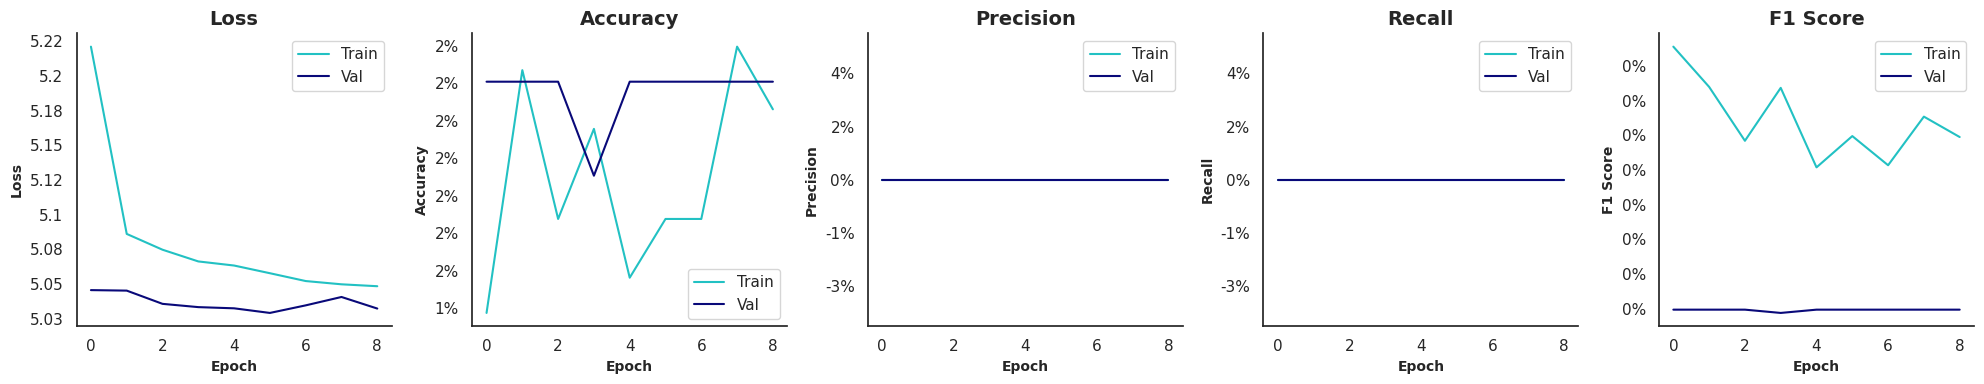

In [14]:
# Evaluate model
from utilities import plot_metrics

os.makedirs("./ModelsEvaluation", exist_ok=True)                                              # Create directory if it doesn't exist
plot_metrics(history, file_path=f"./ModelsEvaluation/2_Training_Validation_Metrics_{datetime.datetime.now().strftime('%Y%m%d')}.png")

In [15]:
# Evaluate on validation and test sets
train_results = {'accuracy': history.history['accuracy'][-1], 'precision': history.history['precision'][-1], 'recall': history.history['recall'][-1], 'f1_score': history.history['f1_score'][-1], 'auc': history.history['auc'][-1]}
val_results = model.evaluate(val_datagen, batch_size=batch_size, return_dict=True, verbose=1)
test_results = model.evaluate(test_datagen, batch_size=batch_size, return_dict=True, verbose=1)

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - accuracy: 0.0237 - auc: 0.7122 - f1_score: 2.2532e-04 - loss: 4.9056 - precision: 0.0000e+00 - recall: 0.0000e+00
18/19 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 0.0235 - auc: 0.7177 - f1_score: 2.2348e-04 - loss: 4.8910 - precision: 0.0000e+00 - recall: 0.0000e+00

2025-04-14 16:15:52.094426: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_2011', 32 bytes spill stores, 32 bytes spill loads

2025-04-14 16:15:52.343487: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_2011', 20 bytes spill stores, 20 bytes spill loads

2025-04-14 16:15:52.516677: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_2011', 148 bytes spill stores, 148 bytes spill loads

2025-04-14 16:15:52.547919: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_2011', 616 bytes spill stores, 532 bytes spill loads



19/19 ━━━━━━━━━━━━━━━━━━━━ 5s 273ms/step - accuracy: 0.0236 - auc: 0.7125 - f1_score: 2.2530e-04 - loss: 4.9051 - precision: 0.0000e+00 - recall: 0.0000e+00


In [16]:
# Display results
from utilities import display_side_by_side, create_evaluation_dataframe
results_df = create_evaluation_dataframe(
    model_name="Baseline Model",
    variation="Original | Grayscale=F | Contrast=F | Saturation=F | Adam=0.001",           # Dataset | Grayscale | Contrast | Saturation | Optimizer=Learning Rate
    train_metrics=train_results, val_metrics=val_results, test_metrics=test_results, train_time=train_time,
    csv_save_path= f"./ModelsEvaluation/2_BaselineModel_TrainingValidationMetrics_{model_name}.csv"      # Save the results to a CSV file
)
display_side_by_side(results_df, super_title="Model Evaluation Results")

Model Evaluation Results 
 
 
 
 
 
 Train 
 Validation 
 Test 
 
 
 
 
 Time of Execution 
 Accuracy 
 Precision 
 Recall 
 F1 Score 
 AUROC 
 Accuracy 
 Precision 
 Recall 
 F1 Score 
 AUROC 
 Accuracy 
 Precision 
 Recall 
 F1 Score 
 AUROC 
 
 
 Model 
 Variation 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 Baseline Model 
 Original | Grayscale=F | Contrast=F | Saturation=F | Adam=0.001 
 833.14 
 0.0243 
 0.0 
 0.0 
 0.0015 
 0.6651 
 0.025 
 0.0 
 0.0 
 0.0002 
 0.665 
 0.025 
 0.0 
 0.0 
 0.0002 
 0.6651

---

# **🔗 Bibliography/References**

**[[1]](https://)** AAAAAAAAAA